# Knowledge graph link prediction with RotatE


<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/complex-link-prediction.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/complex-link-prediction.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

This notebook reproduces the experiments done in the paper [1] that introduced the RotatE algorithm.

[1]Z. Sun, Z.-H. Deng, J.-Y. Nie, and J. Tang, “RotatE: Knowledge Graph Embedding by Relational Rotation in Complex Space,” [arXiv:1902.10197](http://arxiv.org/abs/1902.10197), Feb. 2019.

In table 5, the paper reports several metrics measured on the WN18RR and FB15K-237 datasets including mean rank (MR), mean reciprocal rank (MRR) and Hits at {1, 3, 10}. This notebook measures all of these metrics, as well as "raw" versions of each, for the WN18RR dataset.

## Introduction

The RotatE algorithm is designed for knowledge graphs. These graphs typically consist of a fixed number of nodes or entities, with a large number of edges or relations between them, consisting of many different edge types. All of the information in the graph is captured by the edges and their types. Knowledge graphs are often represented just by their edges, as "triples", consisting of the source ID, the edge type and the target ID.

The RotatE algorithm learns to score these triples. For a fixed embedding dimension $k$, margin $\gamma > 0$ and norm order $p$, the RotatE algorithm learns embedding vectors for the nodes and each edge type. The scoring function is:

$$
f(s, r, t) = \gamma - \| \mathbf{e}_s \circ \mathbf{e}_r - \mathbf{e}_t \|_p
$$

where $\mathbf{e}_x \in \mathbb{C}^k$ is the embedding vector for element $x$ and $\circ$ represents the Hadamard (or, elementwise) product. The edge type embeddings are constrained to have $|\mathbf{e}_r[i]| = 1$ for each index $i$, making them an elementwise rotation of the source embedding.

For correct edges, the rotated source embedding and target embedding should be close together, giving a smaller distance and thus a higher score. For incorrect edges, the embeddings should be far apart, giving a larger distance and thus a lower score.

The model is typically trained by negative sampling, where a small set of correct edges is augmented with a large set of incorrect edges, randomly sampled from the graph. This is done by randomly corrupting either the source or the target nodes of the correct edges.

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.0b

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.0b")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.0b, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
from stellargraph import datasets, utils
from tensorflow.keras import callbacks, optimizers, losses, metrics, regularizers, Model
import numpy as np
import pandas as pd

from stellargraph.mapper import KGTripleGenerator
from stellargraph.layer import RotatE

from IPython.display import HTML

## Initialisation

We need to set up our model parameters, like the number of epochs to train for, and the dimension of the embedding vectors we compute for each node and for each edge type.

The evaluation is performed in three steps:

1. Load the data
2. Train a model
3. Evaluate the model

The [reference implementation](https://github.com/DeepGraphLearning/KnowledgeGraphEmbedding) uses values in the following ranges, depending on the dataset:

- embedding dimension $k$: 500 or 1000
- batch size: 512 or 1024
- number of negative samples: 64 to 1024
- margin $\gamma$: 0.1 to 24
- norm $p$: 2

The best configuration for the WN18RR dataset specifically is as follows.

In [14]:
epochs = 50
embedding_dimension = 500
negative_samples = 16

## WN18RR

The paper uses the WN18RR and FB15k-237 datasets for validation. These datasets are improved versions of the WN18 and FB15k versions: those old versions contain "inverse relations", where `(s, r1, o)` implies `(o, r2, s)` for a pair of relation types `r1` and `r2` (for instance, `_hyponym` ("is more specific than") and `_hypernym` ("is more general than") in WN18).

### Load the data

The dataset comes with a defined train, test and validation split, each consisting of subject, relation, object triples. We can load a `StellarGraph` object with all of the triples, as well as the individual splits as Pandas DataFrames, using the `load` method of the `WN18` dataset.

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [15]:
wn18rr = datasets.WN18RR()
display(HTML(wn18rr.description))
wn18rr_graph, wn18rr_train, wn18rr_test, wn18rr_valid = wn18rr.load()

In [16]:
print(wn18rr_graph.info())

StellarDiGraph: Directed multigraph
 Nodes: 40943, Edges: 93003

 Node types:
  default: [40943]
    Features: none
    Edge types: default-_also_see->default, default-_derivationally_related_form->default, default-_has_part->default, default-_hypernym->default, default-_instance_hypernym->default, ... (6 more)

 Edge types:
    default-_hypernym->default: [37221]
        Weights: all 1 (default)
        Features: none
    default-_derivationally_related_form->default: [31867]
        Weights: all 1 (default)
        Features: none
    default-_member_meronym->default: [7928]
        Weights: all 1 (default)
        Features: none
    default-_has_part->default: [5142]
        Weights: all 1 (default)
        Features: none
    default-_synset_domain_topic_of->default: [3335]
        Weights: all 1 (default)
        Features: none
    default-_instance_hypernym->default: [3150]
        Weights: all 1 (default)
        Features: none
    default-_also_see->default: [1396]
        Weight

### Train a model

The RotatE algorithm consists of some embedding layers and a scoring layer, but the `RotatE` object means these details are invisible to us. The `RotatE` model consumes "knowledge-graph triples", which can be produced in the appropriate format using `KGTripleGenerator`.

In [17]:
wn18rr_gen = KGTripleGenerator(wn18rr_graph, batch_size=512)

wn18rr_rotate = RotatE(
    wn18rr_gen,
    embedding_dimension=embedding_dimension,
    margin=6,
)

wn18rr_inp, wn18rr_out = wn18rr_rotate.in_out_tensors()

wn18rr_model = Model(inputs=wn18rr_inp, outputs=wn18rr_out)

wn18rr_model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.BinaryCrossentropy(from_logits=True),
    metrics=[metrics.BinaryAccuracy(threshold=0.0)],
)

/Users/wil9dw/.pyenv/versions/sg/lib/python3.6/site-packages/ipykernel/__main__.py:6: ExperimentalWarning: RotatE is experimental: demo and documentation is missing (see: https://github.com/stellargraph/stellargraph/issues/1549, https://github.com/stellargraph/stellargraph/issues/1550). It may be difficult to use and may have major changes at any time.


Inputs for training are produced by calling the `KGTripleGenerator.flow` method, this takes a dataframe with `source`, `label` and `target` columns, where each row is a true edge in the knowledge graph.  The `negative_samples` parameter controls how many random edges are created for each positive edge to use as negative examples for training.

In [18]:
wn18rr_train_gen = wn18rr_gen.flow(
    wn18rr_train, negative_samples=negative_samples, shuffle=True
)
wn18rr_valid_gen = wn18rr_gen.flow(wn18rr_valid, negative_samples=negative_samples)

In [19]:
wn18rr_es = callbacks.EarlyStopping(monitor="val_loss", patience=10)
wn18rr_history = wn18rr_model.fit(
    wn18rr_train_gen, validation_data=wn18rr_valid_gen, epochs=epochs, callbacks=[wn18rr_es]
)

Epoch 1/50
170/170 [==============================] - 79s 462ms/step - loss: 0.7564 - binary_accuracy: 0.7061 - val_loss: 0.2189 - val_binary_accuracy: 0.9412
Epoch 2/50
170/170 [==============================] - 80s 473ms/step - loss: 0.1866 - binary_accuracy: 0.9412 - val_loss: 0.1989 - val_binary_accuracy: 0.9412
Epoch 3/50
170/170 [==============================] - 81s 479ms/step - loss: 0.1370 - binary_accuracy: 0.9464 - val_loss: 0.1849 - val_binary_accuracy: 0.9430
Epoch 4/50
170/170 [==============================] - 82s 482ms/step - loss: 0.1008 - binary_accuracy: 0.9570 - val_loss: 0.1739 - val_binary_accuracy: 0.9495
Epoch 5/50
170/170 [==============================] - 81s 479ms/step - loss: 0.0767 - binary_accuracy: 0.9661 - val_loss: 0.1668 - val_binary_accuracy: 0.9553
Epoch 6/50
170/170 [==============================] - 83s 488ms/step - loss: 0.0607 - binary_accuracy: 0.9743 - val_loss: 0.1624 - val_binary_accuracy: 0.9583
Epoch 7/50
170/170 [==========================

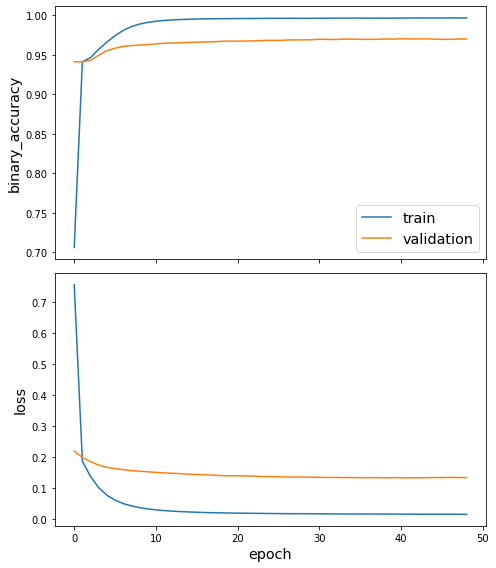

In [20]:
utils.plot_history(wn18rr_history)

### Evaluate the model

We've now trained a model, so we can apply the evaluation procedure from the paper to it. This is done by taking each test edge `E = (s, r, o)`, and scoring it against all mutations `(s, r, n)` and `(n, r, o)` for every node `n` in the graph, that is, doing a prediction for every one of these edges similar to `E`. The "raw" rank is the number of mutated edges that have a higher predicted score than the true `E`.

In [21]:
wn18rr_smaller_gen = KGTripleGenerator(wn18rr_graph, batch_size=64)

wn18rr_raw_ranks, wn18rr_filtered_ranks = wn18rr_rotate.rank_edges_against_all_nodes(
    wn18rr_smaller_gen.flow(wn18rr_test), wn18rr_graph
)

In [22]:
# helper function to compute metrics from a dictionary of name -> array of ranks
def results_as_dataframe(name_to_results):
    return pd.DataFrame(
        name_to_results.values(),
        columns=["MR", "MRR", "hits at 1", "hits at 3", "hits at 10"],
        index=name_to_results.keys(),
    )


def summarise(name_to_ranks):
    return results_as_dataframe(
        {
            name: (
                np.mean(ranks),
                np.mean(1 / ranks),
                np.mean(ranks <= 1),
                np.mean(ranks < 3),
                np.mean(ranks <= 10),
            )
            for name, ranks in name_to_ranks.items()
        }
    )

In [23]:
summarise({"raw": wn18rr_raw_ranks, "filtered": wn18rr_filtered_ranks})

,MR,MRR,hits at 1,hits at 3,hits at 10
raw,3350.191927,0.143224,0.016592,0.116943,0.415763
filtered,3336.286375,0.177886,0.024888,0.187460,0.458360


For comparison, Table 5 in the paper gives the following results for WN18RR. All of the numbers are similar:

In [24]:
results_as_dataframe(
    {"filtered": (3340, 0.476, 0.428, 0.492, 0.571)}
)

,MR,MRR,hits at 1,hits at 3,hits at 10
filtered,3340,0.476,0.428,0.492,0.571


## FB15k-237

Now that we know the process, we can apply the model on the FB15k-237 dataset in the same way.

### Loading the data

In [6]:
fb15k237 = datasets.FB15k_237()
display(HTML(fb15k237.description))
fb15k237_graph, fb15k237_train, fb15k237_test, fb15k237_valid = fb15k237.load()

In [7]:
print(fb15k237_graph.info())

StellarDiGraph: Directed multigraph
 Nodes: 14541, Edges: 310116

 Node types:
  default: [14541]
    Features: none
    Edge types: default-/american_football/football_team/current_roster./sports/sports_team_roster/position->default, default-/award/award_category/category_of->default, default-/award/award_category/disciplines_or_subjects->default, default-/award/award_category/nominees./award/award_nomination/nominated_for->default, default-/award/award_category/winners./award/award_honor/award_winner->default, ... (232 more)

 Edge types:
    default-/award/award_nominee/award_nominations./award/award_nomination/award_nominee->default: [16391]
        Weights: all 1 (default)
        Features: none
    default-/film/film/release_date_s./film/film_regional_release_date/film_release_region->default: [15568]
        Weights: all 1 (default)
        Features: none
    default-/award/award_nominee/award_nominations./award/award_nomination/award->default: [14051]
        Weights: all 1 (de

### Train a model

In [8]:
fb15k237_gen = KGTripleGenerator(
    fb15k237_graph, batch_size=1024  # ~100 batches per epoch
)

fb15k237_rotate = RotatE(
    fb15k237_gen,
    embedding_dimension=embedding_dimension,
    margin=9,
)

fb15k237_inp, fb15k237_out = fb15k237_rotate.in_out_tensors()

fb15k237_model = Model(inputs=fb15k237_inp, outputs=fb15k237_out)
fb15k237_model.compile(
    optimizer=optimizers.Adam(lr=0.001),
    loss=losses.BinaryCrossentropy(from_logits=True),
    metrics=[metrics.BinaryAccuracy(threshold=0.0)],
)

/Users/wil9dw/.pyenv/versions/sg/lib/python3.6/site-packages/ipykernel/__main__.py:8: ExperimentalWarning: RotatE is experimental: demo and documentation is missing (see: https://github.com/stellargraph/stellargraph/issues/1549, https://github.com/stellargraph/stellargraph/issues/1550). It may be difficult to use and may have major changes at any time.


In [9]:
fb15k237_train_gen = fb15k237_gen.flow(
    fb15k237_train, negative_samples=negative_samples, shuffle=True
)
fb15k237_valid_gen = fb15k237_gen.flow(fb15k237_valid, negative_samples=negative_samples)

In [11]:
fb15k237_es = callbacks.EarlyStopping(monitor="val_loss", patience=10)
fb15k237_history = fb15k237_model.fit(
    fb15k237_train_gen, validation_data=fb15k237_valid_gen, epochs=20, callbacks=[fb15k237_es]
)

Epoch 1/20
266/266 [==============================] - 123s 462ms/step - loss: 0.2147 - binary_accuracy: 0.9415 - val_loss: 0.2147 - val_binary_accuracy: 0.9414
Epoch 2/20
266/266 [==============================] - 121s 456ms/step - loss: 0.2062 - binary_accuracy: 0.9415 - val_loss: 0.2107 - val_binary_accuracy: 0.9414
Epoch 3/20
266/266 [==============================] - 121s 454ms/step - loss: 0.2007 - binary_accuracy: 0.9415 - val_loss: 0.2090 - val_binary_accuracy: 0.9414
Epoch 4/20
266/266 [==============================] - 122s 457ms/step - loss: 0.1962 - binary_accuracy: 0.9415 - val_loss: 0.2076 - val_binary_accuracy: 0.9414
Epoch 5/20
266/266 [==============================] - 123s 463ms/step - loss: 0.1918 - binary_accuracy: 0.9415 - val_loss: 0.2067 - val_binary_accuracy: 0.9414
Epoch 6/20
266/266 [==============================] - 123s 461ms/step - loss: 0.1871 - binary_accuracy: 0.9415 - val_loss: 0.2056 - val_binary_accuracy: 0.9414
Epoch 7/20
266/266 [====================

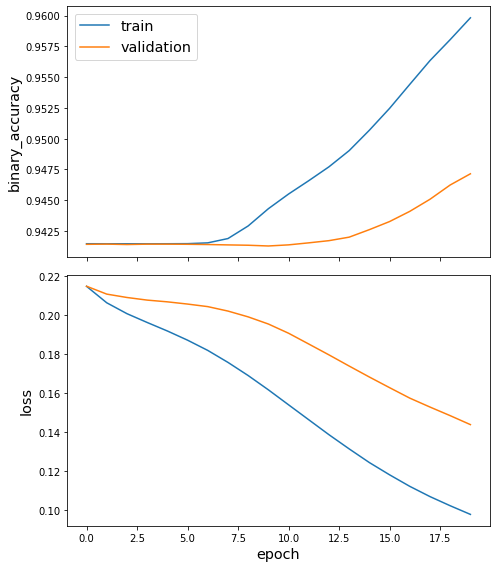

In [12]:
utils.plot_history(fb15k237_history)

### Evaluate the model

In [16]:
fb15k237_smaller_gen = KGTripleGenerator(fb15k237_graph, batch_size=128)

fb15k237_raw_ranks, fb15k237_filtered_ranks = fb15k237_rotate.rank_edges_against_all_nodes(
    fb15k237_smaller_gen.flow(fb15k237_test), fb15k237_graph
)

In [17]:
summarise({"raw": fb15k237_raw_ranks, "filtered": fb15k237_filtered_ranks})

,MR,MRR,hits at 1,hits at 3,hits at 10
raw,1144.302770,0.035017,0.004446,0.011996,0.090907
filtered,983.487149,0.059555,0.004446,0.037623,0.168939


For comparison, Table 5 in the paper gives the following results for FB15k-237:

In [18]:
results_as_dataframe(
    {"filtered": (177, 0.338, 0.241, 0.375, 0.533)}
)

,MR,MRR,hits at 1,hits at 3,hits at 10
filtered,177,0.338,0.241,0.375,0.533


<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/complex-link-prediction.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/complex-link-prediction.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>